# Instal libraries

In [ ]:
# !pip install chembl_webresource_client rdkit seaborn scikit-learn lazypredict

# Import libraries

In [115]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from chembl_webresource_client.new_client import new_client as cc

from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski

from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

import lazypredict
from lazypredict.Supervised import LazyRegressor

import pickle

# Select and retrieve bioactivity data for *SARS coronavirus 2 replicase polyprotein 1ab*

In [3]:
query = cc.target.search('coronavirus')
targets = pd.DataFrame.from_dict(query)
targets

,cross_references,organism,pref_name,score,species_group_flag,target_chembl_id,target_components,target_type,tax_id
0,[],Coronavirus,Coronavirus,17.0,False,CHEMBL613732,[],ORGANISM,11119
1,[],SARS coronavirus,SARS coronavirus,14.0,False,CHEMBL612575,[],ORGANISM,227859
2,[],Feline coronavirus,Feline coronavirus,14.0,False,CHEMBL612744,[],ORGANISM,12663
3,[],Murine coronavirus,Murine coronavirus,14.0,False,CHEMBL5209664,[],ORGANISM,694005
4,[],Human coronavirus 229E,Human coronavirus 229E,12.0,False,CHEMBL613837,[],ORGANISM,11137
5,[],Human coronavirus OC43,Human coronavirus OC43,12.0,False,CHEMBL5209665,[],ORGANISM,31631
6,"[{'xref_id': 'P0C6U8', 'xref_name': None, 'xre...",SARS coronavirus,SARS coronavirus 3C-like proteinase,10.0,False,CHEMBL3927,"[{'accession': 'P0C6U8', 'component_descriptio...",SINGLE PROTEIN,227859
7,[],Middle East respiratory syndrome-related coron...,Middle East respiratory syndrome-related coron...,9.0,False,CHEMBL4296578,[],ORGANISM,1335626
8,"[{'xref_id': 'P0C6X7', 'xref_name': None, 'xre...",SARS coronavirus,Replicase polyprotein 1ab,4.0,False,CHEMBL5118,"[{'accession': 'P0C6X7', 'component_descriptio...",SINGLE PROTEIN,227859
9,[],Severe acute respiratory syndrome coronavirus 2,Replicase polyprotein 1ab,4.0,False,CHEMBL4523582,"[{'accession': 'P0DTD1', 'component_descriptio...",SINGLE PROTEIN,2697049


In [7]:
sarsChemblID =  targets.target_chembl_id[9]
activity = cc.activity
activityFiltered = activity.filter(target_chembl_id = sarsChemblID).filter(standard_type="IC50")
df = pd.DataFrame.from_dict(activityFiltered)

# Handling of missing data

In [12]:
cleanDf = df[df.standard_value.notna()]
cleanDf = cleanDf[cleanDf.canonical_smiles.notna()]
cleanDf.reset_index(drop=True,inplace=True)

# Data preprocessing of bioactivity data

## Labeling compounds as active, inactive or intermediate

Under the IC50 unit, comppounds with values less than 1 micro Molar (1000 nano Molar) are considered **active (1)** while compounds with values greather than 1e4 nM are considered to be **inactive (-1)**. Anything between that is **intermediate (0)**

In [15]:
classFn = lambda x : 1 if float(x) <= 1000 else (-1 if float(x) >= 10000 else 0)

## Simplified data frame of chembl ids, canonical smiles, and standard values

In [17]:
headers = ['molecule_chembl_id','canonical_smiles','standard_value']
simpleDf = cleanDf[headers].assign(bioactivity_class = list(map(classFn,cleanDf.standard_value)))
simpleDf.reset_index(drop=True,inplace=True)

## How to visualise smiles

In [65]:
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.drawOptions.addAtomIndices = False
IPythonConsole.drawOptions.addStereoAnnotation = True

In [176]:
m = Chem.MolFromSmiles(fullDf.canonical_smiles[0])
m.HasProp('_Name')

0

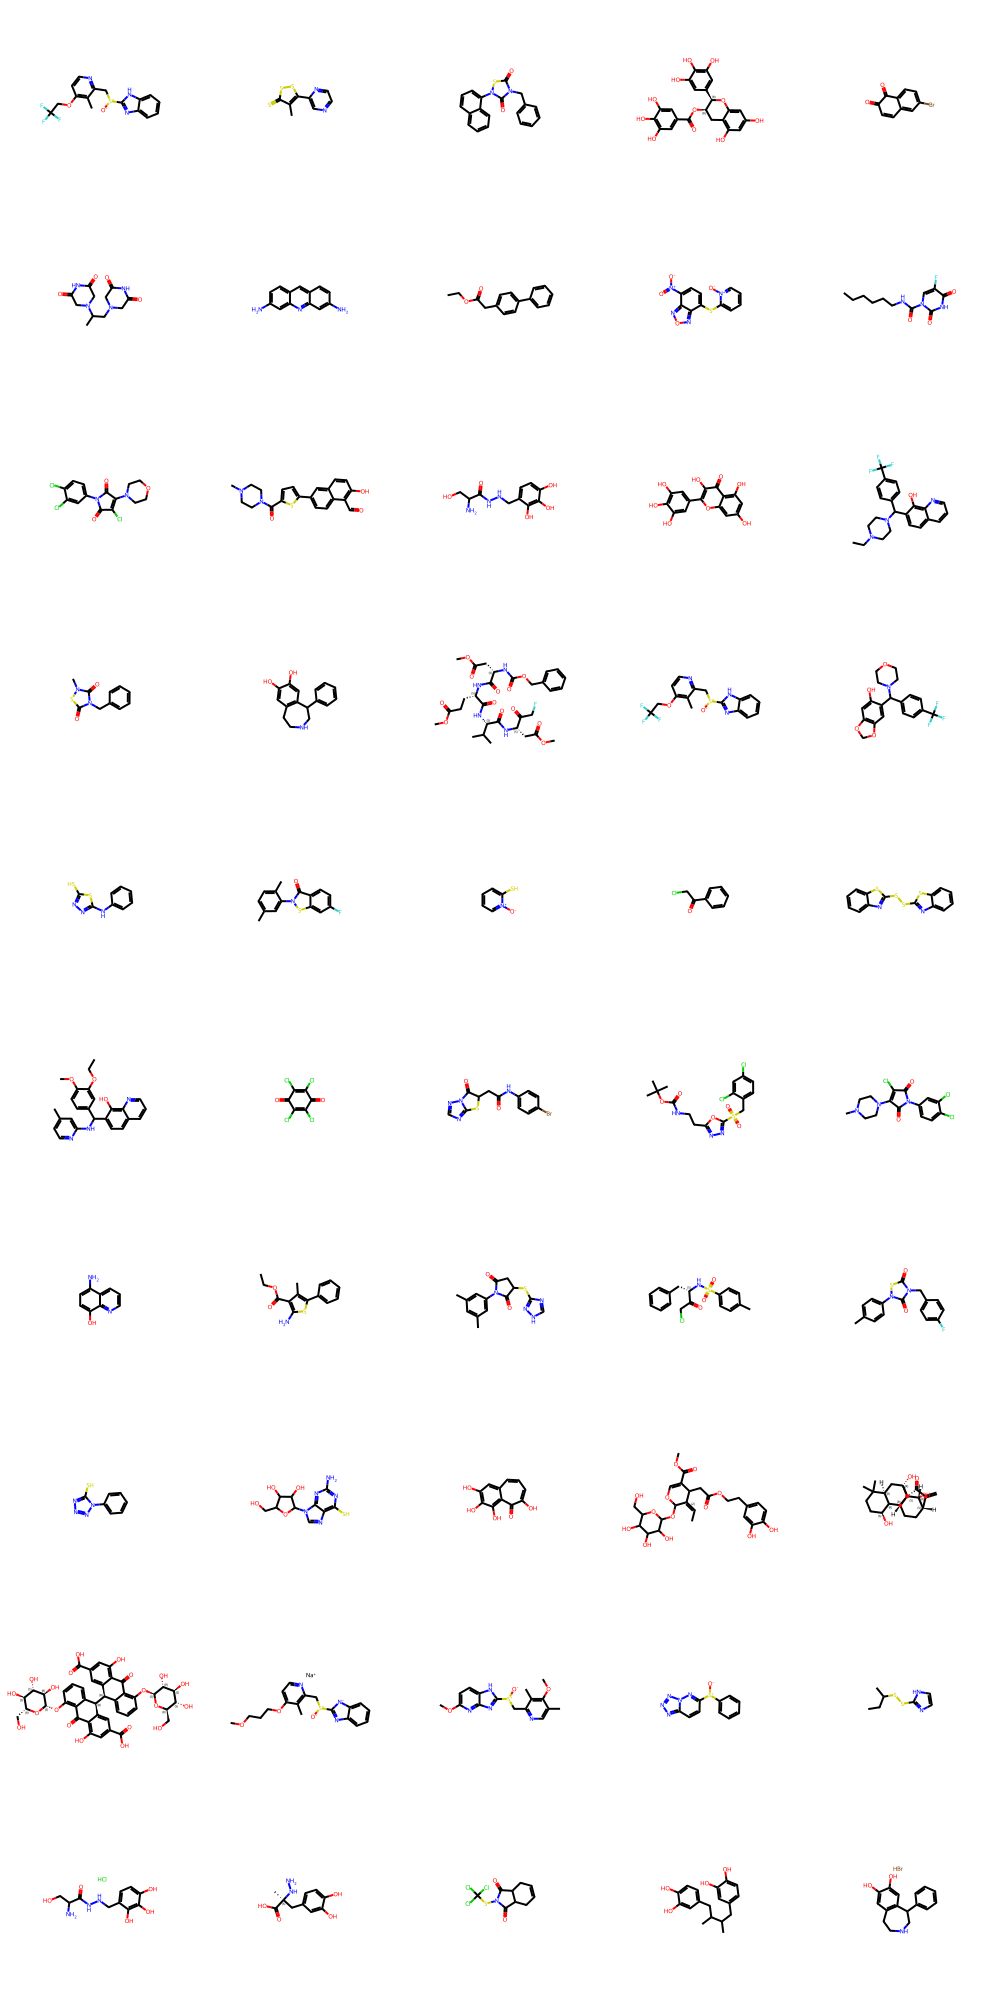

In [76]:
Draw.MolsToGridImage([Chem.MolFromSmiles(s) for s in fullDf.canonical_smiles[:50]], molsPerRow=5, subImgSize=(200,200))

# Calculate Lipinski descriptors to determine the druglikeness of the compounds

The Lipinski's rule is as follows:
- Molecular weight < 500 Dalton
- Octanol-water partition coefficient (LogP) < 5
- Hydrogen bond donors < 5
- Hydrogen bond acceptors < 10 



In [54]:
def lipinski(smiles):
    molData = [Chem.MolFromSmiles(s) for s in smiles]
    descr = ['MolWt','MolLogP']
    ldescr = ['NumHDonors','NumHAcceptors']
    molWt, molLogP = [[getattr(Descriptors,attr)(mol) for mol in molData] for attr in descr]
    numHDonors, numHAcceptors = [[getattr(Lipinski,attr)(mol) for mol in molData] for attr in ldescr]
    dfDict = {"MW":molWt,"LogP":molLogP,"NumHDonors":numHDonors,"NumHAcceptors":numHAcceptors}
    descriptors = pd.DataFrame(dfDict)

    return descriptors

In [56]:
fullDf = pd.concat([simpleDf,lipinski(simpleDf.canonical_smiles)], axis=1)

# Convert IC50 to pIC50 for uniform distribution

In [80]:
fullConvDf = fullDf.astype({'standard_value':'float64'})
fullConvDf = fullConvDf.assign(pIC50=lambda x : [np.max([1,-np.log10(y*1e-9)]) for y in x['standard_value']]) # convert from nM to M and cap the -log at minimum 1
fullConvDf

,molecule_chembl_id,canonical_smiles,standard_value,bioactivity_class,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,CHEMBL480,Cc1c(OCC(F)(F)F)ccnc1C[S+]([O-])c1nc2ccccc2[nH]1,390.0,1,369.368000,3.51522,1,4,6.408935
1,CHEMBL178459,Cc1c(-c2cnccn2)ssc1=S,210.0,1,226.351000,3.30451,0,5,6.677781
2,CHEMBL3545157,O=c1sn(-c2cccc3ccccc23)c(=O)n1Cc1ccccc1,80.0,1,334.400000,3.26220,0,5,7.096910
3,CHEMBL297453,O=C(O[C@@H]1Cc2c(O)cc(O)cc2O[C@@H]1c1cc(O)c(O)...,1580.0,0,458.375000,2.23320,8,11,5.801343
4,CHEMBL4303595,O=C1C=Cc2cc(Br)ccc2C1=O,40.0,1,237.052000,2.22770,0,2,7.397940
...,...,...,...,...,...,...,...,...,...
1133,CHEMBL5220196,CC(C)C[C@H](NC(=O)OCCC12CC3CC(CC(C3)C1)C2)C(=O...,250.0,1,579.692000,-1.38760,4,8,6.602060
1134,CHEMBL5220377,CC(C)C[C@H](NC(=O)OCC12CC3CC(CC(O)(C3)C1)C2)C(...,820.0,1,477.602000,1.66850,4,6,6.086186
1135,CHEMBL5219749,CC(C)C[C@H](NC(=O)OCC12CC3CC(CC(O)(C3)C1)C2)C(...,1030.0,0,581.664000,-2.66280,5,9,5.987163
1136,CHEMBL5218884,[2H]C([2H])(OC(=O)N[C@@H](CC(C)C)C(=O)N[C@H](C...,740.0,1,479.614204,1.66850,4,6,6.130768


In [81]:
fullConvDf.pIC50.describe()

count    1138.000000
mean        6.016533
std         1.127616
min         3.698970
25%         5.175386
50%         6.013228
75%         6.721246
max        10.886057
Name: pIC50, dtype: float64

# Calculate descriptors

In [178]:
selection = ['canonical_smiles','molecule_chembl_id']
fullConvDf[selection].to_csv('resources/molecule.smi', sep='\t', index=False, header=False)
selection = ['molecule_chembl_id','canonical_smiles']
fullConvDf[selection].to_csv('resources/molecule.csv', sep=',', index=False, header=["id",'smiles'])

In [84]:
! pushd resources && bash padel.sh && popd

Processing CHEMBL480 in molecule.smi (1/1138). 
Processing CHEMBL178459 in molecule.smi (2/1138). 
Processing CHEMBL297453 in molecule.smi (4/1138). 
Processing CHEMBL3545157 in molecule.smi (3/1138). 
Processing CHEMBL4303595 in molecule.smi (5/1138). 
Processing CHEMBL444186 in molecule.smi (6/1138). 
Processing CHEMBL55400 in molecule.smi (7/1138). 
Processing CHEMBL1886408 in molecule.smi (8/1138). 
Processing CHEMBL505670 in molecule.smi (9/1138). 
Processing CHEMBL1271993 in molecule.smi (11/1138). Average speed: 0.51 s/mol.
Processing CHEMBL460499 in molecule.smi (10/1138). Average speed: 0.84 s/mol.
Processing CHEMBL3665060 in molecule.smi (12/1138). Average speed: 0.39 s/mol.
Processing CHEMBL1096979 in molecule.smi (13/1138). Average speed: 0.24 s/mol.
Processing CHEMBL164 in molecule.smi (14/1138). Average speed: 0.21 s/mol.
Processing CHEMBL1422849 in molecule.smi (15/1138). Average speed: 0.21 s/mol.
Processing CHEMBL284861 in molecule.smi (16/1138). Average speed: 0.17 s/

### Load descriptors and create dataset

In [165]:
X = pd.read_csv('resources/descriptors_output.csv').drop(columns=['Name'])
y = fullConvDf['pIC50']
dataset = pd.concat([X,y], axis=1)

### Remove low variance features

In [166]:
selection = VarianceThreshold(threshold=(0.9*(1-0.9)))
selection.fit(X)
X = X[X.columns[selection.get_support(indices=True)]]
X.to_csv('resources/descriptor_list.csv',index=False)

### Write dataset to file

In [139]:
dataset.to_csv('resources/sars_coronavirus_2_bioactivity_data_3class_pIC50_pubchem_fp.csv',index=False)

# Comparing classifiers for building classification models

## Input features

### Data split

In [114]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.2)
X_train.shape, y_train.shape

((910, 288), (910,))

### Random Forest regression model

In [120]:
# np.random.seed(1)
model = RandomForestRegressor(n_estimators=300, random_state=24)
model.fit(X, y)

r2 = model.score(X,y)
r2

0.7362759452034361

In [126]:
from sklearn.neighbors import KNeighborsRegressor

In [155]:
# np.random.seed(1)
model2 = KNeighborsRegressor(n_neighbors=12,weights='distance')
model2.fit(X, y)

r22 = model2.score(X,y)
r22

0.7788269410180005

In [121]:
y_pred = model.predict(X)
y_pred

array([6.58019127, 6.42336389, 6.55390171, ..., 6.11548255, 6.16160432,
       6.11548255])

### Model Performance

In [123]:
print(f'Mean squared error (MSE): {mean_squared_error(y,y_pred):.2f}')
print(f'Coefficient of determination (R^2): {r2_score(y,y_pred):.2f}')

Mean squared error (MSE): 0.34
Coefficient of determination (R^2): 0.74


### Data visualisation (experimental vs predicted pIC50 values for training data)

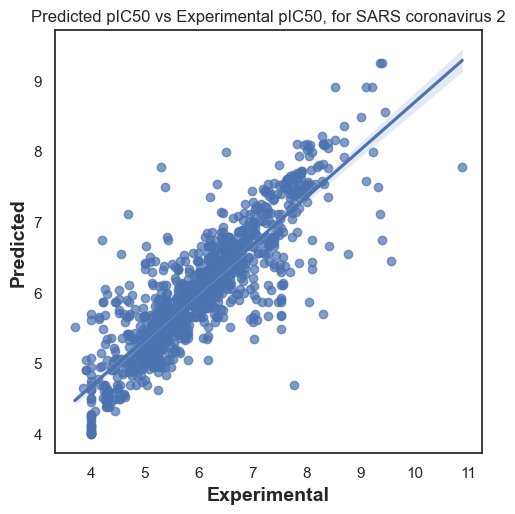

In [125]:
sns.set(color_codes=True)
sns.set_style("white")

plt.figure(figsize=(5.5,5.5))
sns.regplot(x=y,y=y_pred,scatter_kws={'alpha':0.7})

plt.xlabel('Experimental', fontsize=14, fontweight='bold')
plt.ylabel('Predicted', fontsize=14, fontweight='bold')
plt.title('Predicted pIC50 vs Experimental pIC50, for SARS coronavirus 2')
# plt.legend(bbox_to_anchor=(1.05,1), loc=2, borderaxespad=0)

plt.show()

# Save model as pickle object

In [164]:
pickle.dump(model,open('resources/sars_coronavirus_2_model.pkl','wb'))

In [2]:
! pip install htbuilder

You should consider upgrading via the '/Users/sntim/.pyenv/versions/3.9.13/envs/test_env/bin/python3.9 -m pip install --upgrade pip' command.
